## Intro

This project is an example of applying various time series analysis techniques on stock price forecasting as well as preparing a pipeline for possible automated trading.

During inference, the model will go through process shown below. The model training and preparation steps are designed around this requirement.

1. Obtain new daily data from API
2. Perform time series decomposition with all available data (or from historical _x_ years). The model will _not_ learn to predict the seasonal component (which might be easier to learn for more classical ML time series techniques)
3. Input data into model for inference of next day's price (excluding seasonal component)
4. Use seasonality from decomposition to predict what seasonal component will be in the next day's price.
5. Sum them up to get final prediction.




## Importing data from pandas datareader

4 years historical daily data for SPY stock, which tracks the S&P 500, is used. It is roughly one-tenth of the actual S&P index price.

In [2]:
import pandas_datareader.data as web

import datetime

end = datetime.datetime.now()
start = end - datetime.timedelta(days=365 * 4 + 1)

print(start, end)

f = web.DataReader('SPY', 'iex', start, end)

2015-05-14 17:26:42.719970 2019-05-14 17:26:42.719970


## Visualizing the data

Only the closing price is used

In [0]:
# Essential Imports
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style("whitegrid")

In [4]:
# Closing price
display(f.tail(3))

t = pd.to_datetime(f.index.values)
y = f.iloc[:,3].values

,open,high,low,close,volume
date,,,,,
2019-05-09,285.23,287.33,283.30,286.66,103471104
2019-05-10,285.62,288.94,282.30,288.10,112429293
2019-05-13,282.42,283.49,279.93,280.86,127290527


Plotting the data with matplotlib

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


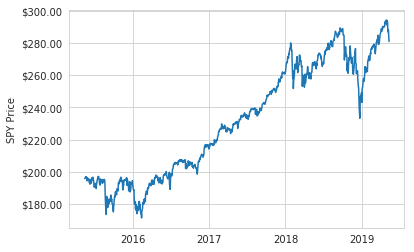

In [5]:
fig, ax = plt.subplots()

def plt_setup_time_axis(ax):
  # Format date x-axis
  years = mdates.YearLocator()
  months = mdates.MonthLocator()
  years_formatter = mdates.DateFormatter('%Y')

  ax.xaxis.set_major_locator(years)
  ax.xaxis.set_major_formatter(years_formatter)
  ax.xaxis.set_minor_locator(months)

  # Autoscale and show plot
  ax.autoscale_view()

# Plot the data
ax.plot_date(t, y, '-')
plt_setup_time_axis(ax)

# Format price y-axis
price_formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(price_formatter)

ax.set_ylabel('SPY Price')
ax.grid(True)
plt.show()

## Test time series decomposition method

The stock price can be regarded as the cumulative result of various components which contribute to how the price may change at each time step. Assuming a multiplicative model (e.g. where price changes in terms of percentage are more reasonable compared to absolute values), the components are related to the price in the following way:

$$y(t) = T * S * R$$

where T is the general trend of the data, S is the seasonality present in the data, and R is the residual component.

The algorithm for decomposition used is the Robust STL algorithm. Since the implementation is designed for additive models, we perform a log transform on $y$ to get

$$log(y) = log(T) + log(S) + log(R)$$

In [6]:
# Log-transform the data to represent multiplicative model as additive model
logy = np.log(y)

print(logy.max(), logy.min())

5.683681802949198 5.14506128644709


In [0]:
import numpy as np
from cvxopt import lapack, solvers
from cvxopt import matrix, spdiag, mul, div


def l1_solver(P, q):
    """
    Returns the solution u of the ell-1 approximation problem

        (primal) minimize ||P*u - q||_1

        (dual)   maximize    q'*w
                 subject to  P'*w = 0
                             ||w||_infty <= 1.
    """

    m, n = P.size

    # Solve equivalent LP
    #
    #     minimize    [0; 1]' * [u; v]
    #     subject to  [P, -I; -P, -I] * [u; v] <= [q; -q]
    #
    #     maximize    -[q; -q]' * z
    #     subject to  [P', -P']*z  = 0
    #                 [-I, -I]*z + 1 = 0
    #                 z >= 0

    c = matrix(n * [0.0] + m * [1.0])
    h = matrix(np.concatenate([q, -q], axis=0))

    def Fi(x, y, alpha=1.0, beta=0.0, trans='N'):
        if trans == 'N':
            # y := alpha * [P, -I; -P, -I] * x + beta*y
            u = P * x[:n]
            y[:m] = alpha * (u - x[n:]) + beta * y[:m]
            y[m:] = alpha * (-u - x[n:]) + beta * y[m:]

        else:
            # y := alpha * [P', -P'; -I, -I] * x + beta*y
            y[:n] = alpha * P.T * (x[:m] - x[m:]) + beta * y[:n]
            y[n:] = -alpha * (x[:m] + x[m:]) + beta * y[n:]

    def Fkkt(W):

        # Returns a function f(x, y, z) that solves
        #
        # [ 0  0  P'      -P'      ] [ x[:n] ]   [ bx[:n] ]
        # [ 0  0 -I       -I       ] [ x[n:] ]   [ bx[n:] ]
        # [ P -I -W1^2     0       ] [ z[:m] ] = [ bz[:m] ]
        # [-P -I  0       -W2      ] [ z[m:] ]   [ bz[m:] ]
        #
        # On entry bx, bz are stored in x, z.
        # On exit x, z contain the solution, with z scaled (W['di'] .* z is
        # returned instead of z).

        d1, d2 = W['d'][:m], W['d'][m:]
        D = 4 * (d1 ** 2 + d2 ** 2) ** -1
        A = P.T * spdiag(D) * P
        lapack.potrf(A)

        def f(x, y, z):
            x[:n] += P.T * (mul(div(d2 ** 2 - d1 ** 2, d1 ** 2 + d2 ** 2), x[n:])
                            + mul(.5 * D, z[:m] - z[m:]))
            lapack.potrs(A, x)

            u = P * x[:n]
            x[n:] = div(x[n:] - div(z[:m], d1 ** 2) - div(z[m:], d2 ** 2) +
                        mul(d1 ** -2 - d2 ** -2, u), d1 ** -2 + d2 ** -2)

            z[:m] = div(u - x[n:] - z[:m], d1)
            z[m:] = div(-u - x[n:] - z[m:], d2)

        return f

    # Initial primal and dual points from least-squares solution.

    # uls minimizes ||P*u-q||_2; rls is the LS residual.
    uls = +q
    lapack.gels(+P, uls)
    rls = P * uls[:n] - q

    # x0 = [ uls;  1.1*abs(rls) ];   s0 = [q;-q] - [P,-I; -P,-I] * x0
    x0 = matrix([uls[:n], 1.1 * abs(rls)])
    s0 = +h
    Fi(x0, s0, alpha=-1, beta=1)

    # z0 = [ (1+w)/2; (1-w)/2 ] where w = (.9/||rls||_inf) * rls
    # if rls is nonzero and w = 0 otherwise.
    if max(abs(rls)) > 1e-10:
        w = .9 / max(abs(rls)) * rls
    else:
        w = matrix(0.0, (m, 1))
    z0 = matrix([.5 * (1 + w), .5 * (1 - w)])

    dims = {'l': 2 * m, 'q': [], 's': []}
    sol = solvers.conelp(c, Fi, h, dims, options=dict(show_progress=False), kktsolver=Fkkt,
                         primalstart={'x': x0, 's': s0}, dualstart={'z': z0})
    return sol['x'][:n]



In [0]:
import numpy as np
import statsmodels.api as sm
from cvxopt import matrix
from sklearn.preprocessing import MinMaxScaler

# Default RobustSTL Options were found from random search over hyperparam space
_rstloptions = {
    "filter_size": 2,
    "denoising_delta_spatial": 3.145,
    "denoising_delta_range": 1.427,
    "seasonal_delta_spatial": 2.062,
    "seasonal_delta_range": 4.406,
    "trend_l1": 1.164,
    "trend_l2": 1.541
}


def extend_seasonal_forecast(x, extension, period=12):
    '''
    Returns an extension of a seasonal forecast array from x for a specified number of time points.
    Only stable for 1D array

    Args:
      x: Numpy array to extend forecast from.
    '''
    if x.shape[0] < period:
        raise Exception("Seasonal data provided is shorter than the required seasonal period!")

    if extension < period:
        return x[-period: -period + extension]
    else:
        raise NotImplementedError("This function cannot generate an extension beyond the period yet.")

def robust_stl(y, period=12, n_iter=1,
               filter_size=_rstloptions["filter_size"],
               denoising_delta_spatial=_rstloptions["denoising_delta_spatial"],
               denoising_delta_range=_rstloptions["denoising_delta_range"],
               seasonal_delta_spatial=_rstloptions["seasonal_delta_spatial"],
               seasonal_delta_range=_rstloptions["seasonal_delta_range"],
               trend_l1=_rstloptions["trend_l1"],
               trend_l2=_rstloptions["trend_l2"]):
    '''
    Applies the RobustSTL algorithm by Wen et al. in https://arxiv.org/pdf/1812.01767.pdf
    to decompose time-series data into Trend, Seasonal, Residual components.
    Designed for the additive model. Use log-transformation if the multiplicative model is desired.
    Applies min-max normalization to data before filtering/extracting seasonality.

    Params:
      y: numpy array to apply STL decomposition
      period: seasonal period length (e.g. 12 months)
      n_iter: number of iterations to apply the robust_stl algorithm
      plot: Boolean to specify if the final output decomposition graphs should be plotted.
      plot_iter: Boolean to specify if the output decomposition graphs after each iteration should be plotted.

      filter_size: Filter size for both bilateral denoising filter and seasonal filter
      denoising_delta_spatial: Parameter to specify how smoothed the denoised data should be in the spatial dimension (t-axis)
      denoising_delta_range: Parameter to specify how smoothed the denoised data should be in the range dimension (y-axis)
      seasonal_delta_spatial:
      seasonal_delta_range:
      trend_l1:
      trend_l2:
    '''
    output_seasonal = np.zeros_like(y)
    output_trend = np.zeros_like(y)

    data = y.copy()
    for i in range(n_iter):
        denoised = bilateral_filter(data, h=filter_size, delta_spatial=denoising_delta_spatial,
                                    delta_range=denoising_delta_range)
        deseasoned = seasonal_difference(denoised, period=period)

        trend_diff = get_trend_difference(data.shape[0], period, deseasoned, l1=trend_l1, l2=trend_l2)
        relative_trend = np.concatenate([np.zeros((1, 1)), np.cumsum(trend_diff, axis=0)])

        contaminated_season = denoised - relative_trend.reshape(-1)
        seasonal = seasonal_filter(contaminated_season, h=filter_size, period=period,
                                   delta_spatial=seasonal_delta_spatial, delta_range=seasonal_delta_range)

        estimated_seasonal, estimated_trend = estimate_components(seasonal, relative_trend, period=period)

        output_seasonal += estimated_seasonal
        output_trend += estimated_trend
        data = y - output_seasonal - output_trend

    output_residual = y - output_seasonal - output_trend
    return output_seasonal, output_trend, output_residual


# Noise Removal
def bilateral_filter(x, h=1, delta_spatial=2, delta_range=1):
    x_filtered = np.zeros_like(x).reshape(-1, 1)

    x_scaler = MinMaxScaler()
    x = x_scaler.fit_transform(x.reshape(-1, 1)).reshape(-1)

    for t in range(x.shape[0]):
        j = np.arange(max(0, t - h), min(x.shape[0], t + h + 1))

        w = np.exp(-0.5 * (np.abs(j - t) / delta_spatial) ** 2 - 0.5 * (np.abs(x[j] - x[t]) / delta_range) ** 2)
        w /= np.sum(w)
        x_filtered[t] = np.sum(w * x[j])

    return x_scaler.inverse_transform(x_filtered).reshape(-1)


def seasonal_difference(x, period=4):
    return x[period:] - x[:-period]


def get_trend_difference(ts_length, period, deseasoned_series, l1=10, l2=0.5):
    # Instantiate numpy arrays as empty/identity first. Preallocated for speed
    empirical_error_indices = np.zeros((ts_length - period, ts_length - 1))
    first_difference_indices = np.identity(ts_length - 1)
    second_difference_indices = np.zeros((ts_length - 2, ts_length - 1))

    # Populate empirical error index matrix
    for i in range(ts_length - period):
        empirical_error_indices[i, i: i + period] = 1

    # Populate second difference index matrix
    for i in range(ts_length - 2):
        second_difference_indices[i, i: i + 2] = np.array([1, -1])

    # L1-norm problem formulation
    P = np.concatenate([empirical_error_indices, l1 * first_difference_indices, l2 * second_difference_indices], axis=0)
    q = np.concatenate([deseasoned_series.reshape(-1, 1), np.zeros((2 * ts_length - 3, 1))], axis=0)
    if P.size == 0 or q.size == 0:
        raise ValueError("Input dimensions cannot be zero!")
    return l1_solver(matrix(P), matrix(q))


def seasonal_filter(x, h=1, period=4, delta_spatial=2, delta_range=1):
    x_filtered = np.zeros_like(x).reshape(-1, 1)

    x_scaler = MinMaxScaler()
    x = x_scaler.fit_transform(x.reshape(-1, 1)).reshape(-1)

    for i in range(x.shape[0]):
        w_vec = np.zeros_like(x)

        for j in range(1 + i // period):
            idx = j * period + i % period
            window = np.arange(max(0, idx - h), min(x.shape[0], idx + h + 1))

            w = np.exp(-0.5 * (np.abs(window - idx) / delta_spatial) ** 2 - 0.5 * (
                        np.abs(x[window] - x[idx]) / delta_range) ** 2)
            w /= w.sum()
            w_vec[window] = w

        x_filtered[i] = np.sum((w_vec / w_vec.sum()) * x)

    return x_scaler.inverse_transform(x_filtered).reshape(-1)


def estimate_components(seasonal, rel_trend, period=12):
    if seasonal.shape[0] // period == 0:
        end_idx = None
    else:
        end_idx = period * (seasonal.shape[0] // period)
    tp1 = seasonal[:end_idx].mean()

    return seasonal - tp1, (rel_trend + tp1).reshape(-1)


In [0]:
_rstloptions = {
    "filter_size": 5,
    "denoising_delta_spatial": 5,
    "denoising_delta_range": 3,
    "seasonal_delta_spatial": 5,
    "seasonal_delta_range": 5,
    "trend_l1": 2,
    "trend_l2": 3
}

seasonal, trend, residual = robust_stl(logy, period=365, n_iter=5)

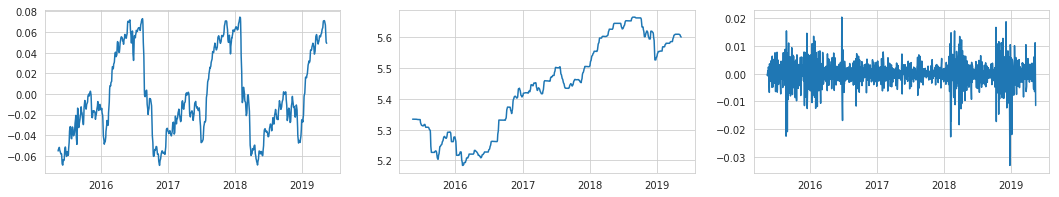

In [10]:
fig,ax = plt.subplots(figsize=(18,3))

ax = plt.subplot(1, 3, 1)
plt.plot(t, seasonal)
plt_setup_time_axis(ax)

ax = plt.subplot(1, 3, 2)
plt.plot(t, trend)
plt_setup_time_axis(ax)

ax = plt.subplot(1, 3, 3)
plt.plot(t, residual)
plt_setup_time_axis(ax)

plt.show()

The selected settings for time series decomposition seems to work fine. Note that this decomposition was done using all the available data. To prevent information leak, when we are designing the models, the decomposition must be redone using the training data alone.

## Prepare preprocessing pipeline

To simplify the problem and to reduce the chance that the model will learn badly, we will assume the seasonality component is independent of the trend and residual. The model will thus only be tasked to take the trend and residual as input, and output the closing price for the next day.

The preprocessing pipeline will consist of the following steps:

Train-test Split $\rightarrow$ TS Decomposition $\rightarrow$ Recombining training data $\rightarrow$ Extract training samples using sliding window $\rightarrow$ Apply local normalization for each training sample

The steps are run and tested manually first, before being put into a single preprocessing function.

#### Preparing train-val-test split

The first 80% of the time series is used as training data, and the next 10% is validation data. The last 10% of the time series will be used to evaluate the final model performance. The sequence must be preserved to prevent information leak into the training or validation data.

In [0]:
# Input desired train-val-test split percentages here
# (test set is automatically calculated to be remainder after subtracting train and val sets.)

def split_dataset(y, split_percentages):
  train_idx = round(split_percentages[0] * y.shape[0])
  train_set = y[:train_idx]

  validation_idx = round((split_percentages[0] + split_percentages[1]) * y.shape[0])
  validation_set = y[train_idx : validation_idx]

  # Rest of the data is sent to test set.
  test_set = y[validation_idx:]
  
  return [
      [train_set, validation_set, test_set],
      [train_idx, validation_idx]
  ]


# Unit Testing
__test_arr = np.arange(20)

datasets, indices = split_dataset(__test_arr, [0.8, 0.1, 0.1])

# Destructure datasets for testing
train_set, validation_set, test_set = datasets
assert train_set.shape[0] == 16
assert validation_set.shape[0] == 2
assert test_set.shape[0] == 2

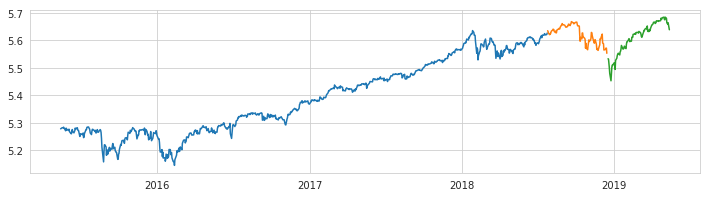

In [12]:
# Generate splits
split_percentages = [0.8, 0.1, 0.1]
datasets, indices = split_dataset(logy, split_percentages)

# Destructure data
train_set, validation_set, test_set = datasets
train_idx, validation_idx = indices

# Plot the split data to visualize what the model will actually be trying to learn/predict
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(t[:train_idx], train_set)
plt.plot(t[train_idx:validation_idx], validation_set)
plt.plot(t[validation_idx:], test_set)

plt_setup_time_axis(ax)

#### Apply TS Decomposition to Training Set

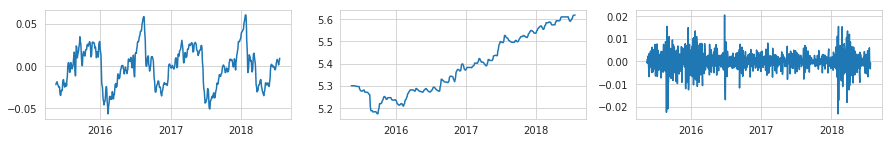

In [13]:
seasonal, trend, residual = robust_stl(train_set, period=365, n_iter=5)

fig,ax = plt.subplots(figsize=(15,2))

ax = plt.subplot(1, 3, 1)
plt.plot(t[:train_idx], seasonal)
plt_setup_time_axis(ax)

ax = plt.subplot(1, 3, 2)
plt.plot(t[:train_idx], trend)
plt_setup_time_axis(ax)

ax = plt.subplot(1, 3, 3)
plt.plot(t[:train_idx], residual)
plt_setup_time_axis(ax)

plt.show()

#### Extract training samples using sliding window

Each training sample will take about 1.25 times of a month's worth of working days, i.e. around 27 days.

If the sequence length to extract is $L_s$ for each sample, and the dataset is of length number $L_T$, the number of samples we can extract is:

$$N_s = L_T - L_s +1$$

In [0]:
def extract_training_samples(train_set, seq_length, ignore_last=False):
  '''
  Extracts subsequence training samples using a sliding window.
  Params:
    train_set: 1- or 2-D array to extract samples from
    seq_length: Length of each subsequence
    ignore_last: If set to True, the final time point in the array will be
        ignored, i.e. it will not appear in any of the training samples.
  '''
  # Convert to np array
  train_set = np.array(train_set)
  
  # Remove last element if ignore last
  train_set = train_set[: -1 if ignore_last else None]
  
  # Prepare one-shifted arrays for each succeeding time step
  # E.g. [1,2], [2,3], [3,4]  
  shifted_arrays = [np.roll(train_set, -i, axis=0)[:-seq_length+1] for i in range(seq_length)]
  
  # Stack the arrays to get sequences and remove the last (seq_length - 1) indices
  # E.g. Rearrange from previous to get:
  # 1 2 3
  # 2 3 4 ...
  
  # Depth-stack for multi-featured time series data
  if train_set.ndim == 1 or train_set.shape[1] == 1:
    stacked_arrays = np.vstack(shifted_arrays).T
  elif train_set.ndim == 2 or train_set.shape[1] > 1:
    stacked_arrays = np.dstack(shifted_arrays)
    stacked_arrays = np.swapaxes(stacked_arrays, axis1=1, axis2=2)
  else:
    raise ValueError("Invalid input dimensions!")
  
  return stacked_arrays

# Unit Testing (Test on both 1D and 2D input)
__test_arr2d = np.array([[1,2,3,4,5,6,7],[1,2,3,4,5,6,7]]).T
__test_output = extract_training_samples(__test_arr2d, 3, ignore_last=True)
assert __test_output.shape == (4, 3, 2)

__test_arr1d = [1,2,3,4,5,6,7]
__test_output = extract_training_samples(__test_arr1d, 3, ignore_last=True)
assert __test_output.shape  == (4, 3)


**Recombining training data, extracting samples, and identifying training data output**

In [17]:
# Sequence length
SEQ_LENGTH = 27

# Recombine trend and residual data into a (Length x Num. features) matrix 
X_train = np.vstack([trend, residual]).T
print("Recombined X has shape of", X_train.shape)

# Extract samples
train_samples = extract_training_samples(X_train, SEQ_LENGTH, ignore_last=True)
print("Training set X has shape of", train_samples.shape)

train_output = (trend + residual)[SEQ_LENGTH:]
print("Target output of training set, Y has shape of", train_output.shape)


Recombined X has shape of (805, 2)
Training set X has shape of (778, 27, 2)
Target output of training set, Y has shape of (778,)


#### Apply local normalization for each training sample

To ensure that the model learns in the most general manner such that it doesn't mthe training sample comes from does not matter, we locally min-max-scale every single sample such that both trend and residual components are scaled from 0 to 1.

In [0]:
class LocalMinMaxScaler:
  def __init__(self):
    self.min = None
    self.max = None
  
  def fit(self, arr):
    self.min = arr.min(axis=1, keepdims=True)
    self.max = arr.max(axis=1, keepdims=True)
  
  def transform(self, arr):
    return ((arr - self.min) / (self.max - self.min))

  def fit_transform(self, arr):
    self.fit(arr)
    return self.transform(arr)

# Unit Testing (Test on both 1D and 2D input)
__test_arr2d = np.array([[1,2,3,4,5,6],[1,2,3,4,5,6]]).T
__test_set2d = extract_training_samples(__test_arr2d, 3)
__test_output = LocalMinMaxScaler().fit_transform(__test_set2d)
assert __test_output.shape == (4, 3, 2) and __test_output.max() == 1.0

__test_arr1d = [1,2,3,4,5,6]
__test_set1d = extract_training_samples(__test_arr1d, 3)
__test_output = LocalMinMaxScaler().fit_transform(__test_set1d)
assert __test_output.shape == (4, 3) and __test_output.max() == 1.0


The output to predict is also modified - the model will aim to predict the next time step value compared to the trend of the previous time step.

$$\hat{y}_{t} = \frac{y_t}{trend_{t-1}}$$

In [19]:
# train_xscaler = LocalMinMaxScaler()
# train_samples_scaled = train_xscaler.fit_transform(train_samples)

train_last_trend_values = train_samples[:, -1, 0]

train_samples_scaled = train_samples.copy()
train_samples_scaled[:, :, 0] -= train_last_trend_values.reshape(-1,1)
train_output_scaled = train_output - train_last_trend_values

print(train_output_scaled.shape)
print(train_output_scaled[:5])

(778,)
[ 0.00189431 -0.00339502 -0.00403932  0.00215775 -0.0125411 ]


#### Prepare validation set (extract samples + local normalize)

The steps above are repeated for the validation set

In [20]:
# Decompose
val_seasonal, val_trend, val_residual = robust_stl(logy[:validation_idx], period=365, n_iter=5)

# Only keep the validation data portion
val_trend = val_trend[train_idx:validation_idx]
val_residual = val_residual[train_idx:validation_idx]

# Recombine trend and residual data for the validation portion into a (Length x Num. features) matrix 
X_val = np.vstack([val_trend, val_residual]).T
print("Recombined X has shape of", X_val.shape)

# Some of the input data to the validation set comes from the training set
X_val_aug = np.concatenate([X_train[-SEQ_LENGTH:], X_val], axis=0)

# Extract samples
val_samples = extract_training_samples(X_val_aug, SEQ_LENGTH, ignore_last=True)
print("Training set X has shape of", val_samples.shape)

val_output = (val_trend + val_residual)
print("Target output of training set Y has shape of", val_output.shape)


Recombined X has shape of (100, 2)
Training set X has shape of (100, 27, 2)
Target output of training set Y has shape of (100,)


In [21]:
# val_xscaler = LocalMinMaxScaler()
# val_samples_scaled = val_xscaler.fit_transform(val_samples)

val_last_trend_values = val_samples[:, -1, 0]
val_samples_scaled = val_samples.copy()
val_samples_scaled[:, :, 0] -= val_last_trend_values.reshape(-1,1)

val_output_scaled = val_output - val_last_trend_values

print(val_output_scaled.shape)
print(val_output_scaled[:5])

(100,)
[ 0.0209256   0.00383084 -0.00033492 -0.00384917  0.00086815]


#### Prepare preprocessing pipeline

To streamline the dataset preparation procedure, a pipeline involving all the required preprocessing steps is prepared. It consists of:

Train-test Split $\rightarrow$ TS Decomposition $\rightarrow$ Recombining training data $\rightarrow$ Extract training samples using sliding window $\rightarrow$ Apply local normalization for each training sample

In [39]:
# Recombine trend and residual data into a (Length x Num. features) matrix 
X = np.vstack([trend, residual]).T
print(X.shape)

(1006, 2)


## Train and test models

In [0]:
%%capture
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

In [0]:
def create_model(input_shape=(27,2,), rnn_units=[256, 128], rnn_dropout=0.3, dense_units=[64], dense_dropout=0.3):
  inputs = tf.keras.Input(shape=input_shape)
  x = inputs
  
  # RNN layers (e.g. GRU)
  # Return sequences on last RNN layer before feeding into dense section
  for idx, rnn in enumerate(rnn_units):
    x = layers.GRU(
        units=rnn,
        activation="tanh",
        recurrent_activation="sigmoid",
        return_sequences=(idx != len(rnn_units) - 1),
    )(x)
    
    x = layers.Dropout(rnn_dropout)(x)
  
  # Dense layers
  for dense in dense_units:
    x = layers.Dense(units=dense)(x)
    x = layers.LeakyReLU(0.05)(x)
    x = layers.Dropout(dense_dropout)(x)
  
  # Final output
  outputs = layers.Dense(1)(x)
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  opt = tf.optimizers.Adam(learning_rate=0.001)
  loss = tf.losses.MeanSquaredError()
  model.compile(optimizer=opt, loss=loss)
  
  print(model.summary())
  return model

In [25]:
training_model = create_model(input_shape=(SEQ_LENGTH,2), rnn_units=[256, 196, 128], rnn_dropout=0.3, dense_units=[64], dense_dropout=0.4)

# Define callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True, verbose=False)

def progress_callback_fn(epoch, logs):
  if epoch % 10 == 0:
    print("Epoch {} ----- Loss: {}, Val loss: {}".format(epoch, logs['loss'], logs['val_loss']))
progress_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=progress_callback_fn)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27, 2)]           0         
_________________________________________________________________
unified_gru (UnifiedGRU)     (None, 27, 256)           199680    
_________________________________________________________________
dropout (Dropout)            (None, 27, 256)           0         
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, 27, 196)           266952    
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 196)           0         
_________________________________________________________________
unified_gru_2 (UnifiedGRU)   (None, 128)               125184    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0     

In [26]:
training_model.fit(
    x=train_samples_scaled, 
    y=train_output_scaled,
    validation_data=(val_samples_scaled, val_output_scaled),
    batch_size=64,
    epochs=500,
    verbose=False,
    callbacks=[model_checkpoint, progress_callback]
)

Epoch 0 ----- Loss: 0.0002096176369405701, Val loss: 4.5445072755683215e-05
Epoch 10 ----- Loss: 3.064385971081668e-05, Val loss: 4.516833112575114e-05
Epoch 20 ----- Loss: 3.0802554387858395e-05, Val loss: 4.373430798295885e-05
Epoch 30 ----- Loss: 2.829562598817855e-05, Val loss: 4.237939763697795e-05
Epoch 40 ----- Loss: 2.7762922778904286e-05, Val loss: 4.253324383171275e-05
Epoch 50 ----- Loss: 2.6500845065702216e-05, Val loss: 3.7652908504242076e-05
Epoch 60 ----- Loss: 2.3579564110821402e-05, Val loss: 2.911195668275468e-05
Epoch 70 ----- Loss: 2.003139834040384e-05, Val loss: 2.8829761722590773e-05
Epoch 80 ----- Loss: 1.909734929005309e-05, Val loss: 2.535372012061998e-05
Epoch 90 ----- Loss: 1.8754063068000553e-05, Val loss: 2.5375583063578234e-05
Epoch 100 ----- Loss: 1.5213787624713303e-05, Val loss: 3.4055938449455425e-05
Epoch 110 ----- Loss: 1.8045539036393166e-05, Val loss: 2.5210124294972048e-05
Epoch 120 ----- Loss: 1.8053861427281572e-05, Val loss: 2.389639354078099e

In [27]:
model = create_model(input_shape=(SEQ_LENGTH,2), rnn_units=[256, 196, 128], rnn_dropout=0.3, dense_units=[64], dense_dropout=0.4)

model.load_weights('model.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 27, 2)]           0         
_________________________________________________________________
unified_gru_3 (UnifiedGRU)   (None, 27, 256)           199680    
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 256)           0         
_________________________________________________________________
unified_gru_4 (UnifiedGRU)   (None, 27, 196)           266952    
_________________________________________________________________
dropout_5 (Dropout)          (None, 27, 196)           0         
_________________________________________________________________
unified_gru_5 (UnifiedGRU)   (None, 128)               125184    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0   

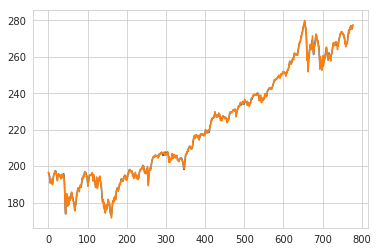

(931.1234999999973, 448.40079958991817)


In [32]:
train_predictions = model.predict(train_samples_scaled)

train_predictions_inverse = train_predictions.flatten() + train_last_trend_values
train_predictions_inverse += seasonal[SEQ_LENGTH:] #extend_seasonal_forecast(seasonal, 1, period=365)

# Anti-log-transform
train_predictions_actual = np.exp(train_predictions_inverse)

plt.plot(train_predictions_actual)
plt.plot(np.exp(train_output + seasonal[SEQ_LENGTH:]))

plt.show()

def evaluate_diff_from_naive(y_pred, y_actual, y_prev):
  return np.sum(np.abs(y_actual - y_prev)), np.sum(np.abs(y_actual - y_pred))

delogged_final_output = np.exp(logy[SEQ_LENGTH:train_idx])

print(evaluate_diff_from_naive(train_predictions_actual[1:], delogged_final_output[1:], delogged_final_output[:-1]))

#### Test validation error for model

The validation error used in model training is only dependent on the trend and residual, i.e. as long as the model can predict trend and residual well, it is deemed successful enough.

We can test it in a more realistic setting, taking seasonality into account, following the inference procedure as outlined earlier. Each succeeding time point is added to the training data, the entire time series is decomposed, the model predicts the next time point (trend + residual), and the seasonality is extended and added to this prediction. This should produce the most realistic predictions.
 
WARNING: This is only possible for small validation sets! In our case, we will do this on a few samples from the test set, not the validation set.

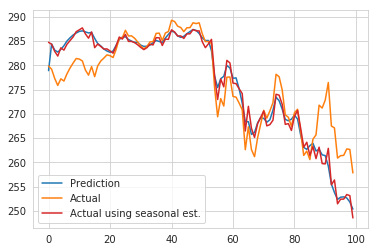

Validation RMSE: 4.991414909729094


In [40]:
val_predictions = model.predict(val_samples_scaled)

val_predictions_inverse = val_predictions.flatten() + val_last_trend_values
seasonal_comp = extend_seasonal_forecast(seasonal, val_predictions.size, period=365)
val_predictions_inverse += seasonal_comp

# Anti-log-transform
val_predictions_actual = np.exp(val_predictions_inverse)

plt.plot(val_predictions_actual.flatten(), label="Prediction")
plt.plot(np.exp(validation_set), label="Actual")
plt.plot(np.exp(val_output + seasonal_comp), label="Actual using seasonal est.", color="C3")
plt.legend(loc='best')

plt.show()

# Show actual error
print("Validation RMSE:", np.sqrt(np.mean((val_predictions_actual - np.exp(validation_set))**2)))

The prediction seems to look quite accurate if the actual seasonal component was left out. Note that the seasonality is extrapolated from the training set to the entire validation set. Since the seasonal component is supposed to be using all data prior to each predicted time point, it is expected that the accuracy of the seasonality identified will decrease.

## Testing model inference

In [0]:
def model_inference(current_data, new_data=None):
  if new_data is not None:
    combined_data = np.concatenate([current_data, new_data], axis=0)
  else:
    combined_data = current_data
  combined_data = np.log(combined_data)
  
  # Robust STL is time consuming for long historical data, so we try to limit its iterations to 1
  _seasonal, _trend, _residual = robust_stl(combined_data, period=365, n_iter=1)
  
  # Take the last SEQ_LENGTH of values as the input to the model
  x_input = np.vstack([_trend[-SEQ_LENGTH:], _residual[-SEQ_LENGTH:]]).T
  
  # Scale by subtracting last value of trend
  trend_last_value = x_input[-1, 0].copy()
  x_input[:, 0] -= trend_last_value
  
  # Resize to 3D tensor
  x_input = np.expand_dims(x_input, axis=0)
  
  # Feed into model
  y_output = model.predict(x_input)
  
  # Add back trend
  y_output += trend_last_value
  
  # Add back seasonality
  y_output += extend_seasonal_forecast(_seasonal, 1, period=365)
  
  # Reverse the log-transform to get actual predicted price
  y_output_actual = np.exp(y_output)
  
  return y_output_actual


# Start with training set only and feed in validation set 1 by 1 for testing...
def evaluate_set(current_data, testing_data):
  final_combined_data = np.concatenate([current_data, testing_data], axis=0)
  
  predicted_outputs = []
  for idx, _ in enumerate(testing_data):
    # Current data + idx of input data
    input_at_this_step = final_combined_data[:current_data.shape[0] + idx]
    predicted_output = model_inference(input_at_this_step)
    
    predicted_outputs.append(predicted_output)
  
  return np.array(predicted_outputs)

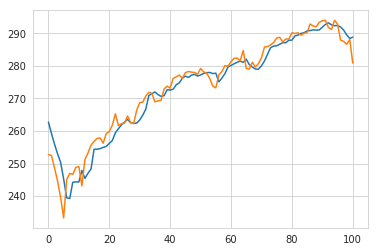

In [45]:
test_predictions_actual = evaluate_set(y[:validation_idx], y[validation_idx:])

plt.plot(test_predictions_actual.flatten())
plt.plot(y[validation_idx:])

We can further evaluate the quality of predictions by playing a simple game: if the prediction is predicted to increase, we will buy 1000 stocks at the current price and sell it at the next time step. Assume no costs involved and that the bid and ask are exactly the same.

In [50]:
earnings = 0

for idx, pred in enumerate(test_predictions_actual):
  # Buy at previous price if predicted increase
  diff = pred - y[validation_idx + idx - 1]
  if diff > 0:
    earnings += 1000 * (y[validation_idx + idx] - y[validation_idx + idx - 1])

print("Result: {} ${}".format("Earn" if earnings >=0 else "Lose", earnings))

Result: Earn $7938.899999999992


Not very good considering the price more or less rose all the way up...

## Limitations

Unfortunately, the change in stock price is not well-correlated to the historical stock price itself, and using the historical stock price to predict what would happen in the future is not correct. More types of data which has a direct effect on the stock price such as an indication of investor sentiment is required to build better and more accurate models.

Importantly, there should be a response lag time between a change in a feature $x$ and the resultant change in stock price $y$, so that the model has time to anticipate the price change and perform an action before it takes effect.